## Outlierdetectie met **Kleuren**afbeeldingen
### Is het een bos, een woestijn of een meer?

Vandaag gaan we aan de slag met **kleurenafbeeldingen** voor outlierdetectie. Specifiek zullen we:

1. Een **autoencoder** gebruiken voor feature-extractie en het detecteren van afwijkingen.
2. Data categoriseren en outliers detecteren met behulp van **KNN (k-Nearest Neighbors)** en **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**.

Dit bouwt voort op ons eerdere werk, met de extra uitdaging van het werken met RGB (kleur) waarden in afbeeldingen.

---

### **Stappenplan**

#### **Stap 0**: Importeer de datasets
- Download en importeer de datasets die beschikbaar zijn gesteld via Teams.

#### **Stap 1**: Herkennen en gebruiken van kleurkanalen
- Begrijp en haal de verschillende **kleurkanalen** (Rood, Groen, Blauw) uit de afbeeldingen.
- Verken hoe deze kanalen bijdragen aan de algemene kenmerken van de afbeeldingen.
- Train een auto encoder alleen op de blauw waardes van de lake images.
- Check hoe deze werkt met een aantal test images (waar je dus ook alleen het blauw kanaal van pakt)
    -   Deze test dataset moet ook een aantal bos / woestijn fotos bevatten




In [45]:
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
os.listdir()

['.DS_Store',
 'autoencoder_output.png',
 'autoencoder_output_2.png',
 'autoencoder_RGB.ipynb',
 'Desert',
 'Forest',
 'Mixed',
 'resized_lake_water',
 'River vs Lake',
 'Werkcollege_7.pptx',
 'Werkcollege_7_RGB.ipynb']

In [22]:
# Functie om foto's te importeren
def import_images(dir):
    image_array = []
    for filename in os.listdir(dir):

        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
            image = cv2.imread(dir + "/" + filename)
            image_array.append(image)
            
        
    return image_array

In [29]:
lake = import_images('resized_lake_water')
mixed = import_images('Mixed')

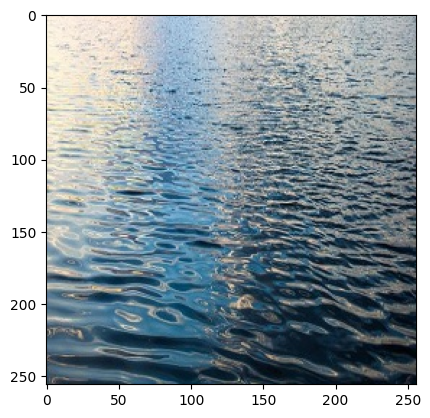

In [33]:
image = lake[0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [26]:
# Extract the blue channel
blue_channel = image[:, :, 0]  # The first channel in BGR is blue

# Resize the blue channel to a fixed size (optional)
resized_blue_channel = cv2.resize(blue_channel, (128, 128), interpolation=cv2.INTER_LINEAR)



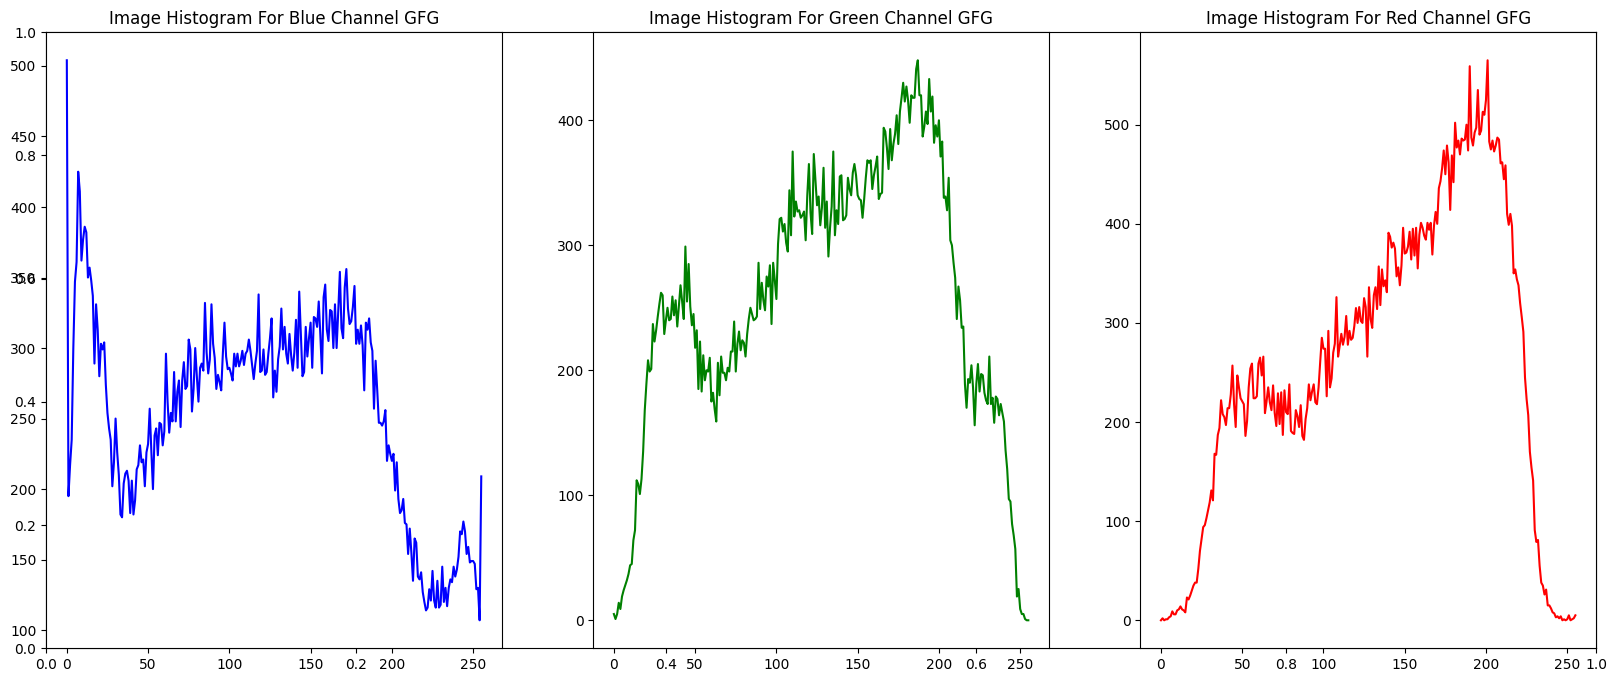

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))
hist_B = cv2.calcHist([image],[0],None,[256],[0,256])
plt.subplot(1, 3, 1)
plt.plot(hist_B, color='b')
plt.title('Image Histogram For Blue Channel GFG')

hist_G = cv2.calcHist([image],[1],None,[256],[0,256])
plt.subplot(1, 3, 2)
plt.plot(hist_G, color='g')
plt.title('Image Histogram For Green Channel GFG')

hist_R = cv2.calcHist([image],[2],None,[256],[0,256])
plt.subplot(1, 3, 3)
plt.plot(hist_R, color='r')
plt.title('Image Histogram For Red Channel GFG')

plt.show()

## Autoencoder trainen

In [48]:
def extract_blue(image_batch):
    blue = image_batch[:, :, :, 2:3]
    blue = tf.cast(blue, tf.float32) / 255.0
    return blue

In [ ]:
image_size = (256, 256)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resized_lake_water",
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

train_dataset = train_dataset.map(extract_blue)
train_dataset = train_dataset.map(lambda x: (x, x))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Found 92 files.


In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Autoencoder for BLUE channel images
input_img = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Latent space
latent = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(latent)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Output layer with 1 channel and sigmoid activation
decoded_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the model
autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)
history = autoencoder.fit(train_dataset, epochs=50, callbacks=[early_stopping])


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step - loss: 0.0855
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step - loss: 0.0725
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 842ms/step - loss: 0.0538
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - loss: 0.0392
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - loss: 0.0301
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - loss: 0.0218
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - loss: 0.0196
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 807ms/step - loss: 0.0165
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 811ms/step - loss: 0.0151
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - loss: 0.0125
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - loss: 0.0114
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - loss: 0.0111
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - loss: 0.0106
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 820ms/step - loss: 0.0097
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - loss: 0.0100
Epoch 16/50
3/3 ━━━

In [70]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Mixed",
    label_mode=None, 
    image_size=image_size,
    batch_size=batch_size
)

test_dataset = test_dataset.map(extract_blue)
test_dataset = test_dataset.map(lambda x: (x, x))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 10 files.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


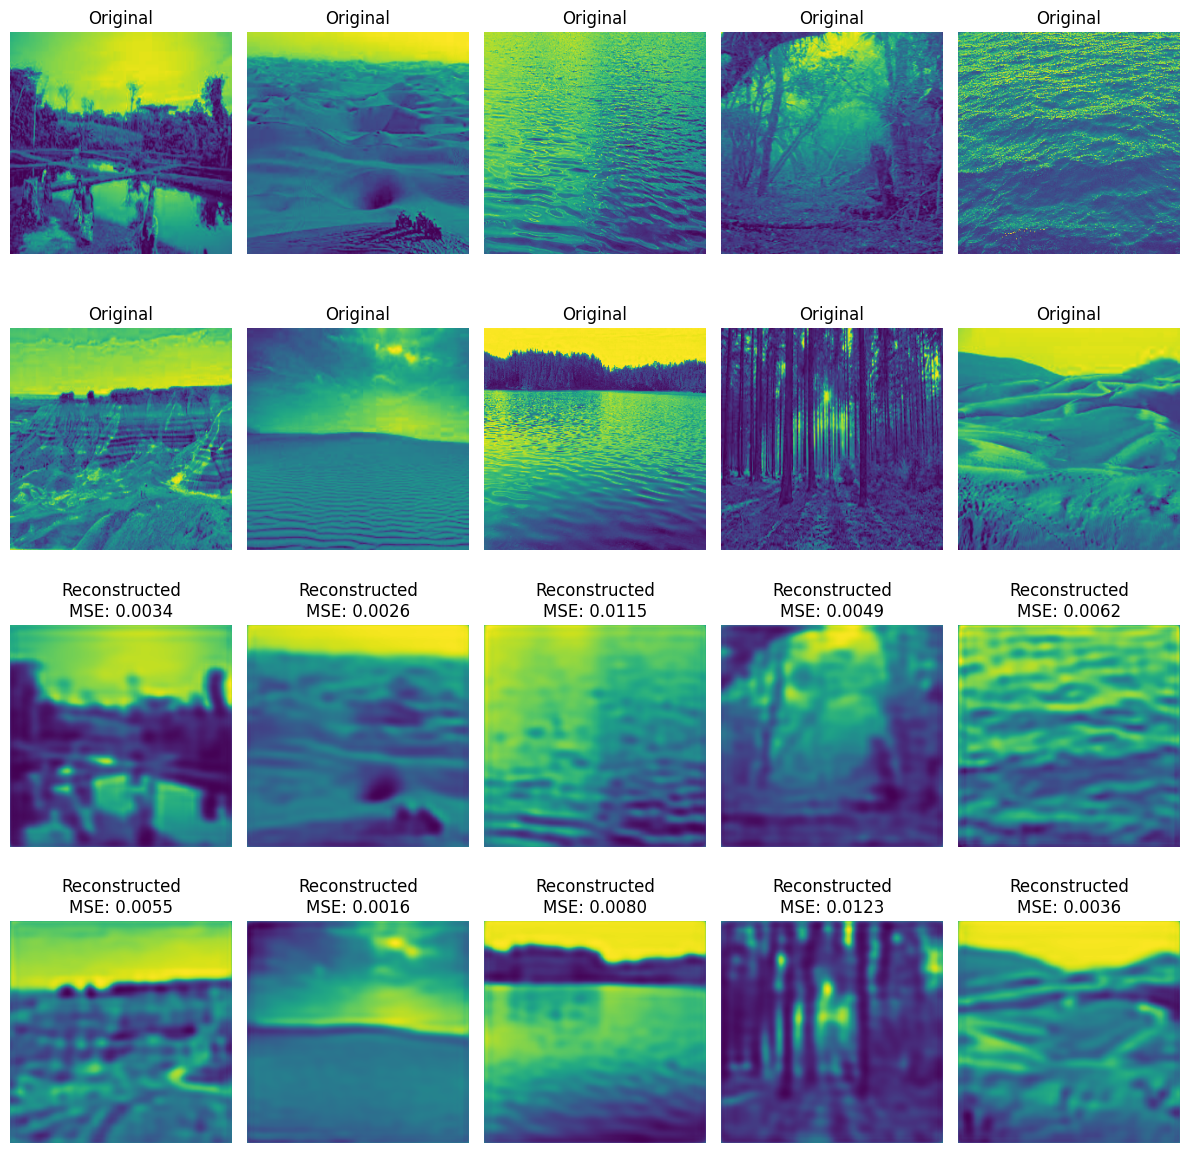

In [74]:
# Take one batch from the dataset
test_images = next(iter(test_dataset))

# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images[0])

# Calculate MSE for each image
mse = np.mean((test_images[0].numpy() - reconstructed_images) ** 2, axis=(1, 2, 3))

# Plot original and reconstructed images with MSE for 10 images in 4 rows
plt.figure(figsize=(12, 12))
for i in range(10):  # Loop over 10 images
    # Original image (Row 1 and 2)
    plt.subplot(4, 5, i + 1)  # First 10 slots for original images
    plt.imshow(test_images[0][i].numpy())
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image (Row 3 and 4)
    plt.subplot(4, 5, i + 11)  # Next 10 slots for reconstructed images
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed\nMSE: {mse[i]:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Stap 2: Kleurenhistogrammen gebruiken om foto's te categoriseren met KNN

In deze stap gebruiken we kleurenhistogrammen om foto's te categoriseren in drie categorieën: **bos**, **woestijn** en **meer**.

Net zoals vorige keer, gaan we een clustering uitvoeren met KNN. Dit keer maken we gebruik van **3 clusters** om de data te groeperen.

Om dit te doen maken we gebruik van de volgende bronnen en de OpenCV-functie `cv2.calcHist`:

- [PyImageSearch: OpenCV Image Histograms](https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/)
- [GeeksforGeeks: cv2.calcHist Methode](https://www.geeksforgeeks.org/python-opencv-cv2-calchist-method/)

---

### Belangrijke Stappen:

1. **Bereken Kleurenhistogrammen**:
   - De functie `calculate_histogram` berekent de RGB-histogrammen voor elke afbeelding en combineert deze tot één enkele featurevector.

2. **Dimensiereductie met PCA**:
   - PCA reduceert de hoog-dimensionale histogramvectoren tot een lagere-dimensionale representatie (in dit geval 10 componenten).

3. **Clustering met K-Means**:
   - K-means wordt toegepast op de PCA-getransformeerde features om de afbeeldingen in 3 categorieën te clusteren.

4. **Visualisatie**:
   - De eerste twee PCA-componenten worden gevisualiseerd in een scatter plot, waarbij de kleuren de clusterlabels representeren.

---


Hiermee kun je een effectieve clustering van foto's uitvoeren op basis van hun kleurinformatie.



In [ ]:
# Code van ChatGPT

import cv2
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a function to calculate color histograms
def calculate_histogram(image_path):
    image = cv2.imread(image_path)  # Read the image
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Calculate histograms for each channel
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()  # Red
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256]).flatten()  # Green
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256]).flatten()  # Blue

    # Concatenate histograms into a single feature vector
    hist_feature = np.concatenate([hist_r, hist_g, hist_b])
    return hist_feature

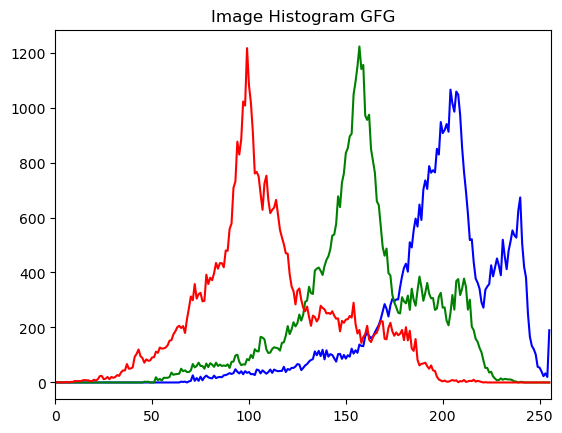

In [18]:
img = desert[0]
  
# define colors to plot the histograms 
colors = ('b','g','r') 
  
# compute and plot the image histograms 
for i,color in enumerate(colors): 
    hist = cv2.calcHist([img],[i],None,[256],[0,256]) 
    plt.plot(hist,color = color) 
plt.title('Image Histogram GFG')
plt.xlim([0, 256])
plt.show()

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

test = calculate_histogram('Mixed/desert.0.jpg')

### Stap 3: Gebruik DBSCAN voor het detecteren van outlier-afbeeldingen

In deze stap maken we gebruik van **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) om outlier-afbeeldingen te detecteren. Dit algoritme is ideaal voor het identificeren van afwijkingen in datasets, zoals afbeeldingen met kleuren die sterk verschillen van de rest.

---

#### **Benodigde stappen**:

1. **Bereken kleurenhistogrammen met OpenCV**:
   - Gebruik de OpenCV-functie `cv2.calcHist` om de RGB-histogrammen van alle afbeeldingen te berekenen.
   - Combineer de histogrammen van de afzonderlijke kleurkanalen (Rood, Groen, Blauw) tot één enkele featurevector per afbeelding.
   - Deze histogrammen dienen als input voor het clustering-algoritme.

2. **Train DBSCAN op vergelijkbare afbeeldingen**:
   - Selecteer een dataset met afbeeldingen die qua kleur sterk op elkaar lijken (bijvoorbeeld alleen foto's van meren of bossen).
   - Pas DBSCAN toe op de kleurenhistogrammen om de structuur van de data te leren en clusters te vormen.

3. **Test op gemengde afbeeldingen**:
   - Stel een testdataset samen die zowel vergelijkbare afbeeldingen bevat (bijvoorbeeld meren) als afbeeldingen met totaal verschillende kleuren (bijvoorbeeld woestijnen of stadsgezichten).
   - Gebruik het getrainde DBSCAN-model om outliers te identificeren. Afbeeldingen die niet binnen een cluster vallen, worden beschouwd als outliers.

4. **Analyseer de resultaten**:
   - Controleer welke afbeeldingen door DBSCAN als outliers worden gemarkeerd.
   - Evalueer de nauwkeurigheid door te vergelijken of de gemarkeerde outliers daadwerkelijk visueel verschillen van de rest van de dataset.

---

#### **Belangrijke punten**:
- **Instellen van parameters**:
  - DBSCAN heeft twee belangrijke parameters: `eps` (de maximale afstand tussen twee punten in een cluster) en `min_samples` (het minimum aantal punten nodig om een cluster te vormen). Experimenteer met deze parameters om optimale resultaten te krijgen.
- **Gebruik PCA voor dimensiereductie**:
  - Als de kleurenhistogrammen een hoge dimensie hebben, kun je PCA gebruiken om het aantal features te reduceren voordat je DBSCAN toepast.
- **Outliers visualiseren**:
  - Maak gebruik van scatter plots of voorbeelden van afbeeldingen om de outliers visueel te inspecteren.

---

Met DBSCAN kun je effectief outliers in een dataset detecteren, vooral wanneer er afbeeldingen met duidelijke kleurverschillen aanwezig zijn. Het combineren van `cv2.calcHist` met een zorgvuldig samengestelde testdataset maakt dit proces krachtig en inzichtelijk.


## Stap 4: Bouw een autoencoder met RGB waardes. 
Een voorbeeld staat gegeven in Teams (autoencoder_RGB.ipynb)
- Voer de stappen uit. Mochten er dingen niet werken, los deze op. 
- Verklein eventueel de foto's zodat deze sneller runt. Of pak een kleinere dataset. 
- Trainen op deze dataset en 50 epochs, duurde voor mij 15 minuten.




## Stap 5: Bouw een Hybride Autoencoder (Optioneel)

Tot nu toe hebben we gewerkt met een **grayscale autoencoder** of een volledige **RGB autoencoder**. 

Ook  hebben we met behulp van `cv2.calcHist` op een efficiënte manier de kleurinformatie van afbeeldingen verkregen.

De volgende stap is om deze twee benaderingen te combineren. 

Kun je een grayscale autoencoder combineren met kleurhistogramwaarden om een snellere en efficiëntere autoencoder te maken die kleurinformatie verwerkt? 

Dit hybride model kan het beste van beide werelden benutten: de eenvoud van grayscale verwerking en de toegevoegde kracht van kleurinformatie.
